<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preamble" data-toc-modified-id="Preamble-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preamble</a></span><ul class="toc-item"><li><span><a href="#Some-general-parameters" data-toc-modified-id="Some-general-parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Some general parameters</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#get_weights_structure" data-toc-modified-id="get_weights_structure-1.2.0.1"><span class="toc-item-num">1.2.0.1&nbsp;&nbsp;</span>get_weights_structure</a></span></li><li><span><a href="#Plot-profile-color" data-toc-modified-id="Plot-profile-color-1.2.0.2"><span class="toc-item-num">1.2.0.2&nbsp;&nbsp;</span>Plot profile color</a></span></li><li><span><a href="#Profile-black-points" data-toc-modified-id="Profile-black-points-1.2.0.3"><span class="toc-item-num">1.2.0.3&nbsp;&nbsp;</span>Profile black points</a></span></li><li><span><a href="#Plot-gray-profile" data-toc-modified-id="Plot-gray-profile-1.2.0.4"><span class="toc-item-num">1.2.0.4&nbsp;&nbsp;</span>Plot gray profile</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#An-example-of-recall" data-toc-modified-id="An-example-of-recall-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>An example of recall</a></span><ul class="toc-item"><li><span><a href="#The-example" data-toc-modified-id="The-example-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>The example</a></span></li><li><span><a href="#Matrix-variability" data-toc-modified-id="Matrix-variability-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Matrix variability</a></span></li></ul></li><li><span><a href="#General-plot" data-toc-modified-id="General-plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>General plot</a></span><ul class="toc-item"><li><span><a href="#Load-an-example-to-plot" data-toc-modified-id="Load-an-example-to-plot-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Load an example to plot</a></span></li><li><span><a href="#The-plot" data-toc-modified-id="The-plot-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>The plot</a></span></li></ul></li></ul></div>

# Preamble

In [1]:
import  pprint
import  subprocess 
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline

np.set_printoptions(suppress=True, precision=5)

from network import Protocol, NetworkManager, Network
from patterns_representation import PatternsRepresentation
from analysis_functions import calculate_persistence_time, calculate_recall_quantities,calculate_triad_connectivity
from plotting_functions import plot_weight_matrix, plot_network_activity_angle, plot_persistent_matrix

## Some general parameters

In [2]:
epsilon = 1e-7
vmin = -3.0
remove = 0.010
dt = 0.001

from_index = 5
to_index = 4

tau_z_pre = 0.025
tau_z_post = 0.005

In [3]:
lw = 8
ms = 20
alpha_graph = 0.3
colors = sns.color_palette()
plt.rcParams['figure.figsize'] = (14, 10)
sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})

## Functions

#### get_weights_structure

In [4]:
def get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                          tau_z_post, include_first=False):
    
    strict_maximum = True

    g_a = 1.0
    g_I = 10.0
    tau_a = 0.250
    G = 25.0
    sigma_out = 0.0
    tau_s = 0.010
    
    hypercolumns = 2
    minicolumns = 11
    n_patterns = minicolumns

    # Training protocol
    training_times = training_time
    training_times = [training_times for i in range(n_patterns)]
    inter_pulse_interval = inter_pulse_interval
    inter_pulse_intervals = [inter_pulse_interval for i in range(n_patterns)]
    inter_sequence_interval = 0.0
    resting_time = 0.0
    epochs = 1

    values_to_save = ['o']

    # Neural Network
    nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
                 tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
                 strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
    # Build the representation
    representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                            minicolumns=minicolumns)

    # Build the protocol
    protocol = Protocol()
    protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

    # Run the protocol
    timed_input = manager.run_network_protocol_offline(protocol=protocol)

    
    ws = nn.w[from_index, from_index]
    wn = nn.w[to_index, from_index]
    wb = nn.w[from_index - 1, from_index]
    wr = nn.w[to_index + 1, from_index]
    alphas = [nn.w[1 + i, 0] - nn.w[2 + i, 0] for i in range(4)]
    
    if include_first:
        range_rests = list(range(from_index, minicolumns))
        w_rests = nn.w[from_index:minicolumns, from_index]
        range_backs = list(range(0, to_index))
        w_backs = nn.w[:(to_index), from_index]
    else:
        range_rests = list(range(to_index + 1, minicolumns))
        w_rests = nn.w[(to_index + 1):minicolumns, from_index]
        range_backs = list(range(0, to_index - 2))
        w_backs = nn.w[:(to_index - 2), from_index]

    results_dictionary = {}
    results_dictionary['ws'] = ws
    results_dictionary['wn'] = wn
    results_dictionary['wb'] = wb
    results_dictionary['wr'] = wr
    results_dictionary['w_rests'] = w_rests
    results_dictionary['range rests'] = range_rests
    results_dictionary['w_backs'] = w_backs
    results_dictionary['range backs'] = range_backs
    results_dictionary['w'] = nn.w[:minicolumns, from_index]
    results_dictionary['diff_next'] = ws - wn
    results_dictionary['diff_rest'] = wn - wr
    results_dictionary['r'] = (wn - wr) / (ws - wn)
    results_dictionary['alphas'] = alphas    
    
    return results_dictionary 

#### Plot profile color

In [5]:
def plot_profile_color(training_times_vector, ax=None):
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    colors1 = sns.color_palette("Reds", num)
    colors2 = sns.color_palette("Blues", num)

    inter_pulse_interval = 0
    
    for index, training_time in enumerate(training_times_vector):
        results_dictionary = get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                                                   tau_z_post, include_first=True)
        w_backs = results_dictionary['w_backs']
        range_backs = results_dictionary['range backs']
        w_rests = results_dictionary['w_rests']
        range_rests = results_dictionary['range rests']

        ax.plot(range_rests, w_rests, 'o-', color=colors1[index], ms=ms, lw=lw)
        ax.plot(range_backs, w_backs, 'o-', color=colors2[index], ms=ms, lw=lw)
        ax.plot(from_index, results_dictionary['ws'], 'o', color='black', ms=ms)

    ax.set_title('Connectivity profile')
    ax.set_xlabel('Unit')
    ax.set_ylabel('w')
    
    ax.axvline(from_index, ls='--', color='black')
    
    return ax 

#### Profile black points

In [6]:
def plot_profile_black_points(training_times_vector, ax=None):
    num = training_times_vector.size
    colors1 = sns.color_palette("Reds", num)
    colors2 = sns.color_palette("Blues", num)

    inter_pulse_interval = 0

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)


    for index, training_time in enumerate(training_times_vector):
        results_dictionary = get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                                                   tau_z_post, include_first=True)

        w_here = results_dictionary['w']
        w_backs = results_dictionary['w_backs']
        range_backs = results_dictionary['range backs']
        w_rests = results_dictionary['w_rests']
        range_rests = results_dictionary['range rests']

        ax.plot(w_here, 'o', ms=ms, color='black')
        ax.plot(range_rests, w_rests, ls='-', lw=lw, color=colors1[index])
        ax.plot(range_backs, w_backs, ls='-', lw=lw, color=colors2[index])

    ax.set_title('Connectivity profile')
    ax.set_xlabel('Unit id')
    ax.set_ylabel('w')
    
    ax.axvline(from_index, ls='--', color='black')

    return ax

#### Plot gray profile

In [7]:
def plot_profile_grays(training_times_vector, ax=None, title=False):
    
    num = int(training_times_vector.size * 1.5)
    colors = sns.color_palette("Greys_r", num)

    inter_pulse_interval = 0
    
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        
    
    for index, training_time in enumerate(training_times_vector):
        results_dictionary = get_weights_structure(training_time, inter_pulse_interval, tau_z_pre, 
                                                   tau_z_post, include_first=False)
        w = results_dictionary['w']
        ax.plot(w, 'o-', color=colors[index], ms=ms, lw=lw)
    
    if title:
        ax.set_title('Connectivity profile')
    
    ax.set_xlabel('Unit id')
    ax.set_ylabel('w')
    
    ax.axvline(from_index, ls='--', color='black')

    
    return ax

# An example of recall

## The example

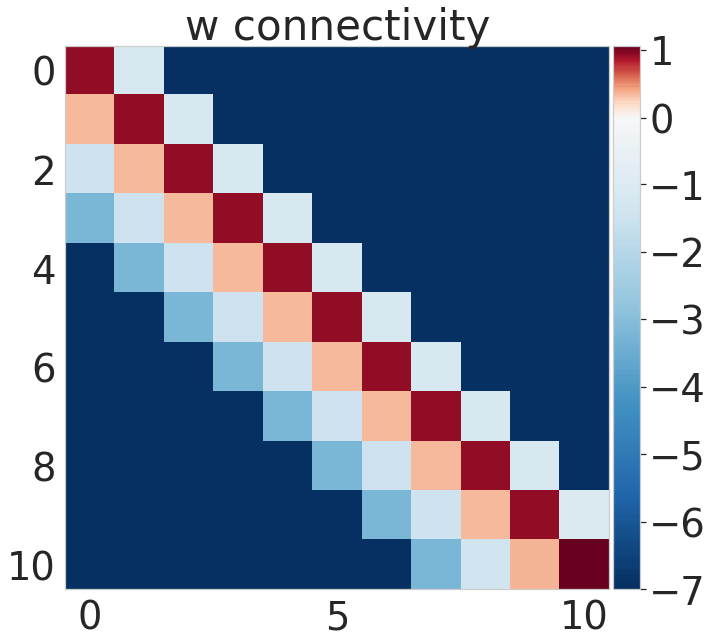

In [8]:
strict_maximum = True

g_a = 1.0
g_I = 2.0
tau_a = 0.250
G = 25.0
sigma_out = 0.0
tau_s = 0.010

hypercolumns = 2
minicolumns = 11
n_patterns = minicolumns

# Training protocol
training_times = 0.100
training_times = [training_times for i in range(n_patterns)]
inter_pulse_intervals = [0 for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
             tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
             strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)
plot_weight_matrix(manager);

In [9]:
T_persistence = 0.100
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
T_recall = T_persistence * minicolumns
T_cue = 1 * tau_s
nr = manager.canonical_network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove,
                                  reset=True, empty_history=True)

Text(0.5,1,'$T_{persistence}$ = 0.1 (s)')

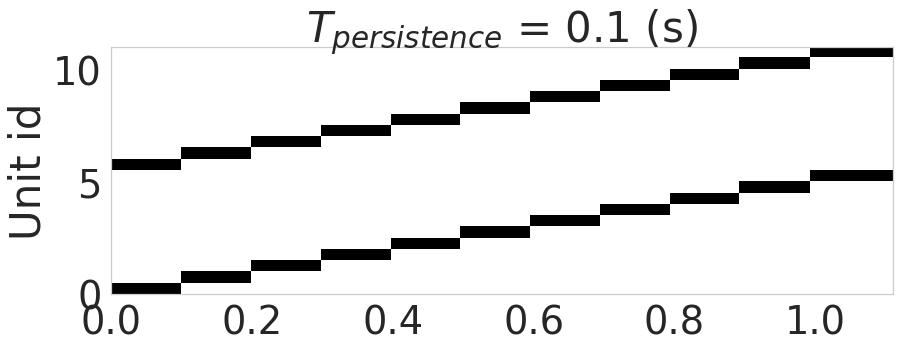

In [10]:
cmap = matplotlib.cm.binary
o1 = manager.history['o']
fig = plt.figure()
ax = fig.add_subplot(211)
extent = [0, manager.T_recall_total, 0, minicolumns]
ax.imshow(o1.T, cmap=cmap, origin='lower', aspect='auto', extent=extent)

ax.set_ylabel('Unit id')
ax.set_title(r'$T_{persistence}$ = ' + str(T_persistence) + ' (s)')

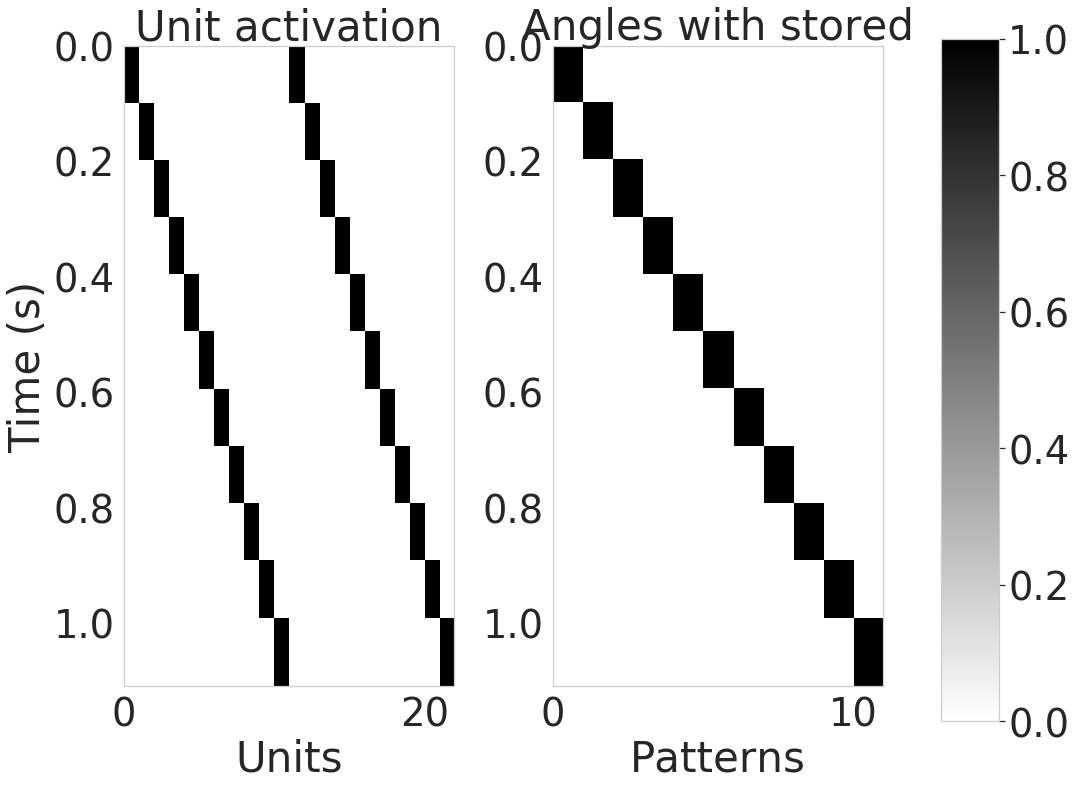

In [11]:
plot_network_activity_angle(manager, cmap=cmap)

## Matrix variability

In [12]:
if False:
    num = 10
    training_times_vector = np.linspace(0.020, 1.0, num=num)
    plot_profile_color(training_times_vector)
    plot_profile_black_points(training_times_vector)
    plot_profile_grays(training_times_vector);

# General plot

## Load an example to plot

In [13]:
strict_maximum = True

g_a = 1.0
g_I = 2.0
tau_a = 0.250
G = 25.0
sigma_out = 0.0
tau_s = 0.010


hypercolumns = 2
minicolumns = 11
n_patterns = minicolumns

# Training protocol
training_times = 0.100
training_times = [training_times for i in range(n_patterns)]
inter_pulse_intervals = [0 for i in range(n_patterns)]
inter_sequence_interval = 0.0
resting_time = 0.0
epochs = 1

# Manager properties
values_to_save = ['o']

# Neural Network
nn = Network(hypercolumns, minicolumns, G=G, tau_s=tau_s, tau_z_pre=tau_z_pre, tau_z_post=tau_z_post,
             tau_a=tau_a, g_a=g_a, g_I=g_I, sigma_out=sigma_out, epsilon=epsilon, prng=np.random,
             strict_maximum=strict_maximum, perfect=False, normalized_currents=True)


# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)
# Build the representation
representation = PatternsRepresentation(manager.canonical_activity_representation[:n_patterns],
                                        minicolumns=minicolumns)

# Build the protocol
protocol = Protocol()
protocol.simple_protocol(representation, training_times=training_times, inter_pulse_intervals=inter_pulse_intervals, inter_sequence_interval=inter_sequence_interval, epochs=epochs, resting_time=resting_time)

# Run the protocol
timed_input = manager.run_network_protocol_offline(protocol=protocol)

T_persistence = 0.100
manager.set_persistent_time_with_adaptation_gain(T_persistence=T_persistence)
T_recall = T_persistence * minicolumns 
T_cue = 1 * tau_s
nr = manager.canonical_network_representation
aux = calculate_recall_quantities(manager, nr, T_recall, T_cue, remove=remove,
                                  reset=True, empty_history=True)

In [14]:
from analysis_functions import calculate_angle_from_history

num = 10
training_times_vector = np.linspace(0.020, 0.500, num=num)

## The plot

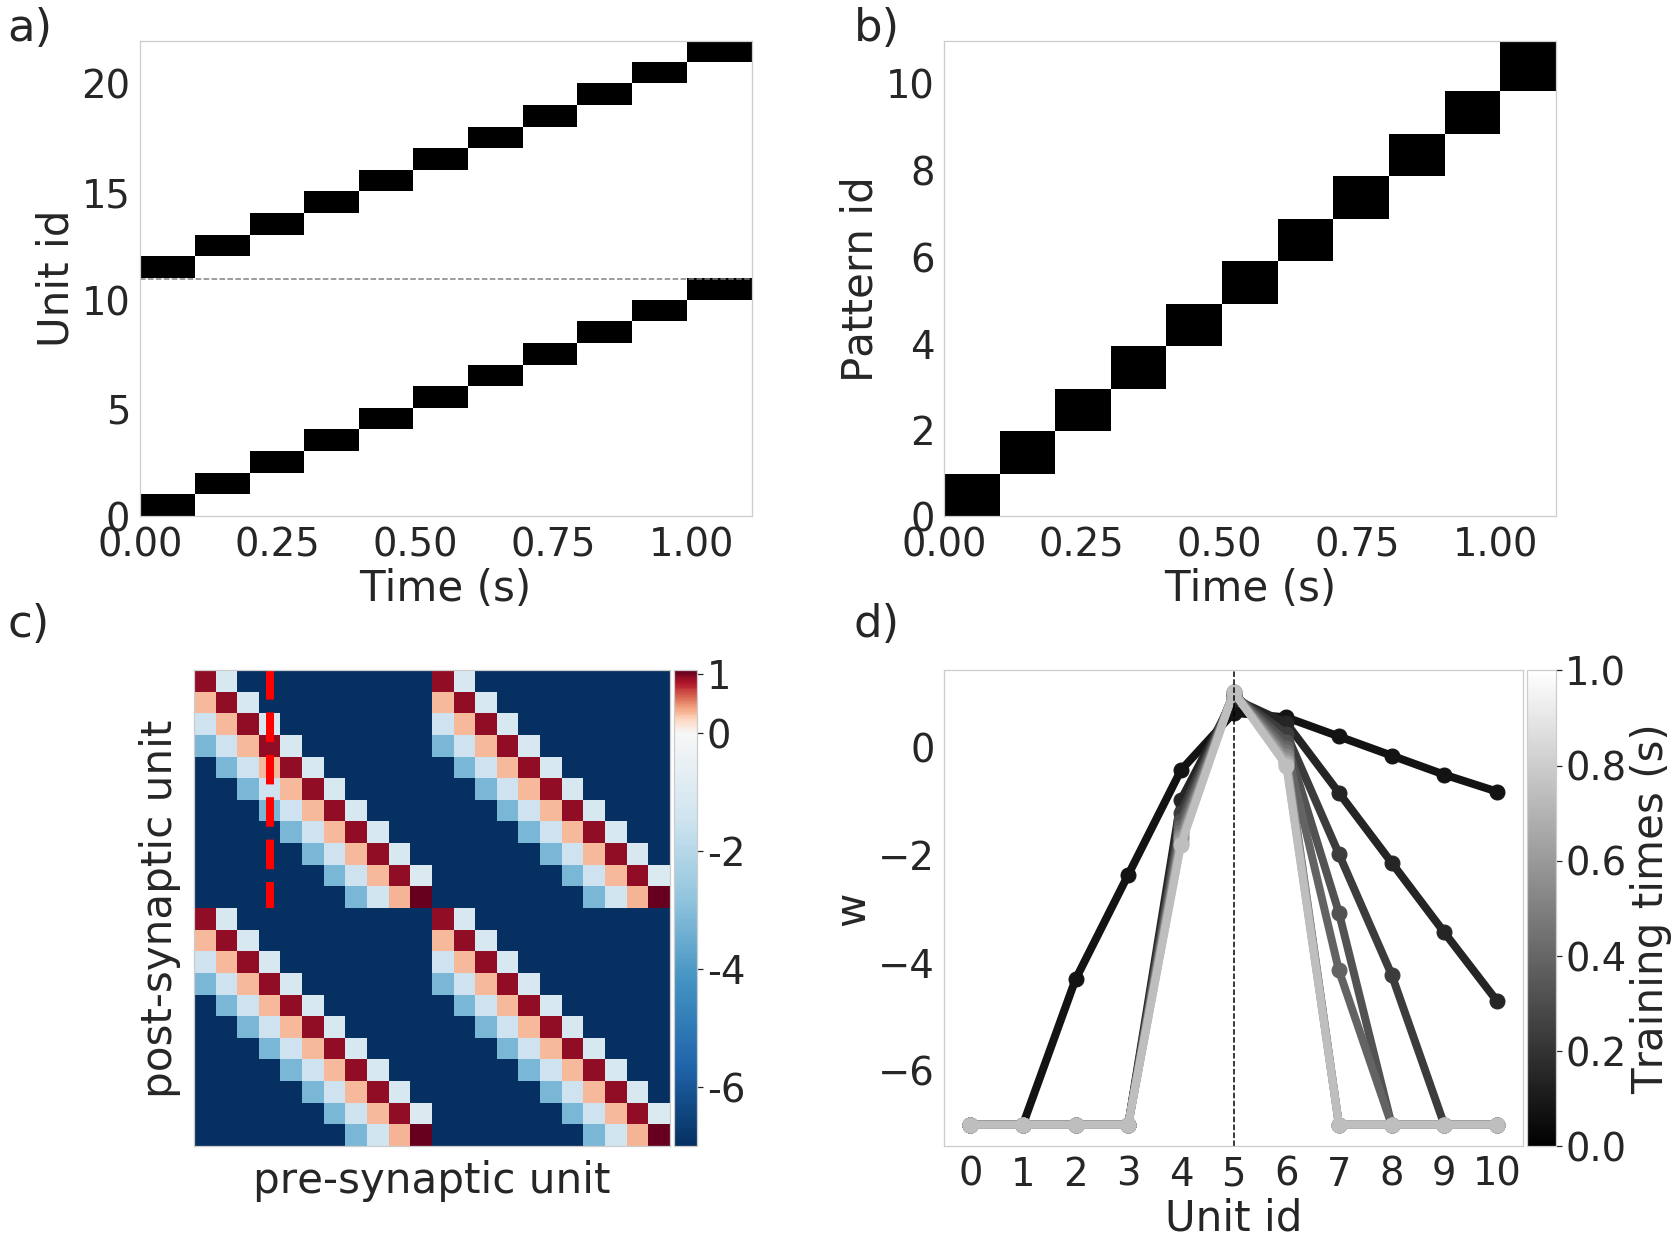

In [15]:

sns.set(font_scale=3.5)
sns.set_style("whitegrid", {'axes.grid': False})

size_factor = 1.5
lw = 8
ms = 15
save = True
captions = True
size = 45
legend = False
gray = True
one_hypercolum = False
title = False
cmap = matplotlib.cm.binary

fig = plt.figure(figsize=(int(size_factor * 16), int(size_factor * 12)))
gs = gridspec.GridSpec(2, 2)

####################
# The recall example
############

# a)
ax1 = fig.add_subplot(gs[0, 0])
o1 = manager.history['o']
extent = [0, manager.T_recall_total, 0, minicolumns * hypercolumns]
ax1.imshow(o1.T, cmap=cmap, origin='lower', aspect='auto', extent=extent)
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Unit id')
ax1.axhline(minicolumns, ls='--', color='gray')

# b)
ax2 = fig.add_subplot(gs[0, 1])
extent = [0, manager.T_recall_total, 0, minicolumns]
angles = calculate_angle_from_history(manager)
ax2.imshow(angles, cmap=cmap, origin='lower', aspect='auto', extent=extent)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Pattern id')

# The matrix
ax_matrix = fig.add_subplot(gs[1, 0])
ax_matrix = plot_weight_matrix(manager, one_hypercolum=one_hypercolum, ax=ax_matrix, title=False)
ax_matrix.set_xlabel('pre-synaptic unit')
ax_matrix.set_ylabel('post-synaptic unit')
ax_matrix.xaxis.set_ticklabels([])
ax_matrix.yaxis.set_ticklabels([])

num_points = 20
x = np.ones(num_points) * 3
y = np.linspace(-0.5, minicolumns - 0.5, num=num_points)
ax_matrix.plot(x, y, '--', lw=lw, color='red')

# Modify the colorbar
im = ax_matrix.images        #this is a list of all images that have been plotted
cbar = im[-1].colorbar
cbar.set_ticks([-6, -4, -2, 0, 1])
cbar.set_ticklabels([-6, -4, -2, 0, 1])

# The profile
ax_profile = fig.add_subplot(gs[1, 1])
ax_profile = plot_profile_grays(training_times_vector, ax=ax_profile, title=title);


# Fix the x-axis of the profile
if True:
    xlabels_points = np.array([1, 3, 5, 7, 9], dtype='int')
    xlabels_points = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype='int')
    xlocations = xlabels_points
    xlabels_string = [f'{x}' for x in xlabels_points]
    ax_profile.xaxis.set_major_locator(plt.FixedLocator(xlocations))
    ax_profile.xaxis.set_major_formatter(plt.FixedFormatter(xlabels_string))

# Add a colorbar to the profile
cmap = matplotlib.cm.gray
# cmap = cmap=plt.cm.get_cmap('Grays', int(1.5 * num))
divider = make_axes_locatable(ax_profile)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb1 = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, orientation='vertical')
cb1.set_label('Training times (s)')

fig.tight_layout()    

if captions:
    xpoint1 = 0.01
    xpoint2 = 0.50
    
    ypoint1 = 0.96
    ypoint2 = 0.50
    
    fig.text(xpoint1, ypoint1, 'a)', size=size)
    fig.text(xpoint2, ypoint1, 'b)', size=size)
    fig.text(xpoint1, ypoint2, 'c)', size=size)
    fig.text(xpoint2, ypoint2, 'd)', size=size)



if save:
    directory = '../plot_producers/'
    file_name = 'recall_example' 

    format_string = '.pdf'
    string_to_save = directory + file_name + format_string
    fig.savefig(string_to_save, frameon=False, dpi=110, bbox_inches='tight')

In [16]:
training_times_vector

array([0.02   , 0.07333, 0.12667, 0.18   , 0.23333, 0.28667, 0.34   ,
       0.39333, 0.44667, 0.5    ])

In [17]:
epsilon

1e-07